# Compute $k^*(n)$ for $n$ qubit Bacon-Shor Hamiltonians

## Setup

In [10]:
from typing import List

import numpy as np
import pandas as pd

import cirq
import openfermion as of
from openfermion.utils import count_qubits

from kcommute import get_si_sets, r_hat_measurement_count, compute_blocks

import matplotlib.pyplot as plt

### Set parameters

In [11]:
size = 10               # Linear size of the lattice for the Bacon-Shor code. There are size ^ 2 total qubits.
save_results = False    # Whether or not to save results.

## Helper functions

In [12]:
def bacon_shor_hamiltonian(m1, m2):

    def coords_to_index(i, j):
        return i * m1 + j

    qs = cirq.GridQubit.rect(m1, m2)
    stabilizers: List[of.QubitOperator] = []
    # X-type stabilizers.
    for i in range(m1 - 1):
        for j in range(m2):
            if j == 0:
                stabilizer = of.QubitOperator(f"X{coords_to_index(i, j)} X{coords_to_index(i+1, j)}")
            else:
                stabilizer *= of.QubitOperator(f"X{coords_to_index(i, j)} X{coords_to_index(i+1, j)}")
        stabilizers.append(stabilizer)
    # Z-type stabilizers.
    for j in range(m2 - 1):
        stabilizer = of.QubitOperator()
        for i in range(m1):
            if i == 0:
                stabilizer = of.QubitOperator(f"Z{coords_to_index(i, j)} Z{coords_to_index(i, j+1)}")
            else:
                stabilizer *= of.QubitOperator(f"Z{coords_to_index(i, j)} Z{coords_to_index(i, j+1)}")
        stabilizers.append(stabilizer)

    hamiltonian = sum(stabilizers)
    return hamiltonian

In [13]:
def groups_rhat_vs_k(qs, hamiltonian, verbose=False):
    nq = count_qubits(hamiltonian)
    kvals = list(range(1, nq + 1))
    rhats: List[float] = []
    ngroups: List[int] = []

    for k in kvals:
        blocks = compute_blocks(qs, k)
        groups = get_si_sets(hamiltonian, blocks=blocks)
        ngroups.append(len(groups))
        rhats.append(r_hat_measurement_count(groups))
        if verbose:
            print("On k =", k)
            # print("Blocks are:")
            # print(blocks)
            print(f"Finished grouping, there are {len(groups)} groups.")
            # print("Groups are:")
            # print(groups)
            print("rhat =", rhats[-1])
    return kvals, ngroups, rhats

## Run script

In [14]:
results_dict = {}

hamiltonian = bacon_shor_hamiltonian(size, size)
nq = count_qubits(hamiltonian)
qs = cirq.LineQubit.range(nq)
kvals, ngroups, rhats = groups_rhat_vs_k(qs, hamiltonian, verbose=True)
results_dict[size] = {"kvals": kvals, "ngroups": ngroups, "rhats": rhats}

On k = 1
Finished grouping, there are 2 groups.
rhat = 9.0
On k = 2
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 3
Finished grouping, there are 2 groups.
rhat = 9.0
On k = 4
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 5
Finished grouping, there are 2 groups.
rhat = 12.344638885155298
On k = 6
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 7
Finished grouping, there are 2 groups.
rhat = 9.0
On k = 8
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 9
Finished grouping, there are 2 groups.
rhat = 9.0
On k = 10
Finished grouping, there are 1 groups.
rhat = 18.000000000000004
On k = 11
Finished grouping, there are 2 groups.
rhat = 9.0
On k = 12
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 13
Finished grouping, there are 2 groups.
rhat = 9.113942310619057
On k = 14
Finished grouping, there are 2 groups.
rhat = 9.82812026740972
On k = 15
Finished grouping, there are 2 groups

## Parse/save results

In [15]:
# Convert the data to a dataframe by first converting to a list of tuples.
tuple_list = []
for size, inner_dict in results_dict.items():
    for k, ng, rhat in zip(inner_dict["kvals"], inner_dict["ngroups"], inner_dict["rhats"]):
        tuple_list.append((size, k, ng, rhat))
df = pd.DataFrame.from_records(tuple_list, columns=["size", "k", "ngroups", "rhat"])

In [16]:
df.set_index(["size", "k"], inplace=True)

if save_results:
    df.to_csv(f"bacon_shor_results_{size}.csv")

## Plot results

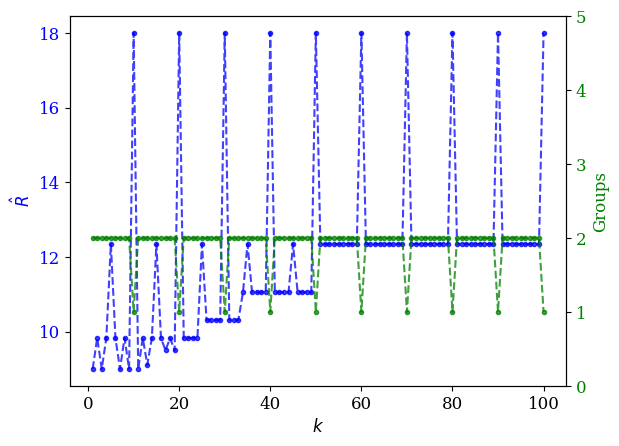

In [17]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(kvals, rhats, "--.", color="blue", alpha=0.75)
ax2.set_ylim(0, 5)
ax2.plot(kvals, ngroups, "--.", color="green", alpha=0.75)
ax1.set_xlabel("$k$")

ax1.set_ylabel(r"$\hat{R}$", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")

ax2.set_ylabel(r"Groups", color="green", fontsize=12)
ax2.tick_params(axis="y", labelcolor="green")

plt.xlabel("$k$");
# plt.savefig("baconshor.pdf")

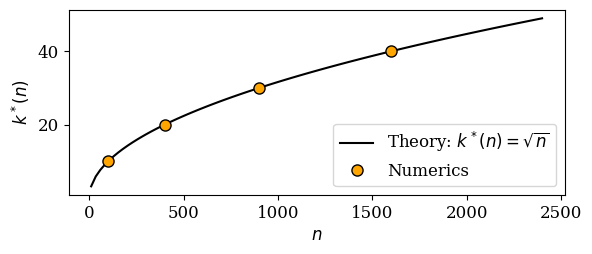

In [18]:
plt.figure(figsize=(6.4, 2.4))
sizes = [10, 20, 30, 40]
nvals = [s ** 2 for s in sizes]

numerics = [10, 20, 30, 40]  # See bacon_shor_results_XX.csv for XX in (10, 20, 30, 40).

xvals = np.linspace(10, 2400, 100)
plt.plot(xvals, np.sqrt(xvals), color="black", label="Theory: $k^*(n) = \sqrt{n}$")
plt.plot(nvals, sizes, "o", ms=8, mec="black", alpha=0.999, color="orange", label="Numerics")

plt.xlabel("$n$")
plt.ylabel("$k^*(n)$")

plt.legend();
# plt.savefig("baconshorkstar.pdf")